In [1]:
%pip install tensorflow==2.10.1 tensorflow-gpu==2.10.0 opencv-python matplotlib --user

  Using cached tensorflow-2.10.1-cp310-cp310-win_amd64.whl (455.9 MB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached flatbuffers-23.3.3-py2.py3-none-any.whl (26 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached protobuf-3.19.6-cp310-cp310-win_amd64.whl (895 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflowjs 3.19.0 requires protobuf==3.20.0, but you have protobuf 3.19.6 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
#standard imports
import cv2
import os
import numpy as np
import random
from matplotlib import pyplot as plt


In [2]:
#tensorflow imports
# from tensorflow import keras
# from keras.models import Model
# from keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Flatten, Input
# from tensorflow.python.compat import dtensor as dtensor_api

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Flatten, Input

import tensorflow as tf


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
try:
    os.makedirs(POS_PATH)
    os.makedirs(NEG_PATH)
    os.makedirs(ANC_PATH)
except:
    print("already exists")

already exists


In [46]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [47]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [6]:
#Import uuid library to generate unique names for images
import uuid

In [13]:
video_capture = cv2.VideoCapture(0)
while video_capture.isOpened():
    ret, video_data = video_capture.read()
    # color = cv2.cvtColor(video_data, cv2.COLOR_BGR2GRAY)
    
    #Cut the image to 250x250px
    video_data = video_data[120:120+250,200:200+250,:]

    #collect anchor images
    if cv2.waitKey(1) == ord("a"):
        #Create unique image name
        imgName = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgName, video_data)
        

    #collect positive images
    if cv2.waitKey(1) == ord("p"):
        #Create unique image name
        imgName = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgName, video_data)
        
    # face = face_capture.detectMultiScale(
    #     color,
    #     scaleFactor=1.1,
    #     minNeighbors=3,
    #     flags=cv2.CASCADE_SCALE_IMAGE,
    #     minSize=(30, 30),
    # )

    # for(x, y, w, h) in face:
    #     cv2.rectangle(video_data, (x, y), (x+w, y+h), (0, 255, 0), 2)

    cv2.imshow("video_live", video_data)
    if cv2.waitKey(10) == ord("q"):
        break
video_capture.release()
cv2.destroyAllWindows()


Data Augmentation


In [7]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
        
        data.append(img)
    
    return data

In [8]:
import os
import uuid

In [13]:
#testing for a single image
img_path = os.path.join(ANC_PATH, '1a1e09cf-e0be-11ed-9e09-001a7dda7112.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [12]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

Get Image Directories

In [14]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [15]:
dir_test = anchor.as_numpy_iterator()


In [16]:
dir_test.next()

b'data\\anchor\\58f941fe-e5ec-11ed-be84-001a7dda7112.jpg'

Preprocessing


In [17]:
def preprocess(file_path):
    
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    return img

In [18]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [19]:
samples = data.as_numpy_iterator()
example = samples.next()

In [20]:
example

(b'data\\anchor\\1f70dc78-e0be-11ed-82a7-001a7dda7112.jpg',
 b'data\\positive\\31923071-e5ec-11ed-a70d-001a7dda7112.jpg',
 1.0)

Build Train and Test Partition


In [21]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [22]:
res = preprocess_twin(*example)


In [23]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
# data = data.shuffle(buffer_size=1024)  # old buffer size
data = data.shuffle(buffer_size=10000)

In [24]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [25]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

Build Embedding Layer

In [26]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')


In [27]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [28]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [29]:
embedding = make_embedding()

In [30]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

Build Distance Layer

In [31]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()

    #similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

Make Siamese Model

In [32]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [33]:
siamese_model = make_siamese_model()

In [34]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

Training

Setup Loss and Optimizer

In [35]:
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()

In [36]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001
opt

Establish Checkpoints

In [37]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [38]:
test_batch = train_data.as_numpy_iterator()


In [39]:
batch_1 = test_batch.next()


In [40]:
X = batch_1[:2]
len(X)


2

In [41]:
y = batch_1[2]
y


array([0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

Build Training Step Function

In [42]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

Build Training Loop

In [43]:
# Import metric calculations
# from tensorflow.keras.metrics import Precision, Recall
from tensorflow.python.keras.metrics import Precision, Recall

In [44]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

Train the model

In [45]:
EPOCHS = 50

In [46]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
263/263 [==============================] - 154s 494ms/step
0.063033484 0.9476689 0.996997

 Epoch 2/50
263/263 [==============================] - 126s 479ms/step
0.030571818 0.9752852 0.99854016

 Epoch 3/50
263/263 [==============================] - 121s 458ms/step
5.4613133e-06 0.98695654 0.9960995

 Epoch 4/50
263/263 [==============================] - 120s 458ms/step
0.021176739 0.9871734 0.9971209

 Epoch 5/50
263/263 [==============================] - 119s 452ms/step
0.10703741 0.99201876 0.99669814

 Epoch 6/50
263/263 [==============================] - 120s 454ms/step
0.23698479 0.98565966 0.99421406

 Epoch 7/50
263/263 [==============================] - 120s 456ms/step
0.03012711 0.99382424 0.998568

 Epoch 8/50
263/263 [==============================] - 120s 456ms/step
0.040223394 0.99812293 0.9976548

 Epoch 9

Evaluate Model


In [47]:
# Import metric calculations
from tensorflow.python.keras.metrics import Precision, Recall

In [48]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [49]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[1.0316496e-10],
       [1.0000000e+00],
       [9.9998176e-01],
       [3.2142181e-10],
       [4.3368839e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999964e-01],
       [2.1166986e-10],
       [1.0000000e+00],
       [1.8580365e-11],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [4.0003878e-10]], dtype=float32)

In [50]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]

In [51]:
y_true


array([0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.],
      dtype=float32)

In [52]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [53]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [151]:
# r = Recall()
# p = Precision()

# for test_input, test_val, y_true in test_data.as_numpy_iterator():
#     yhat = siamese_model.predict([test_input, test_val])
#     r.update_state(y_true, yhat)
#     p.update_state(y_true,yhat) 

# print(r.result().numpy(), p.result().numpy())

Viz Results

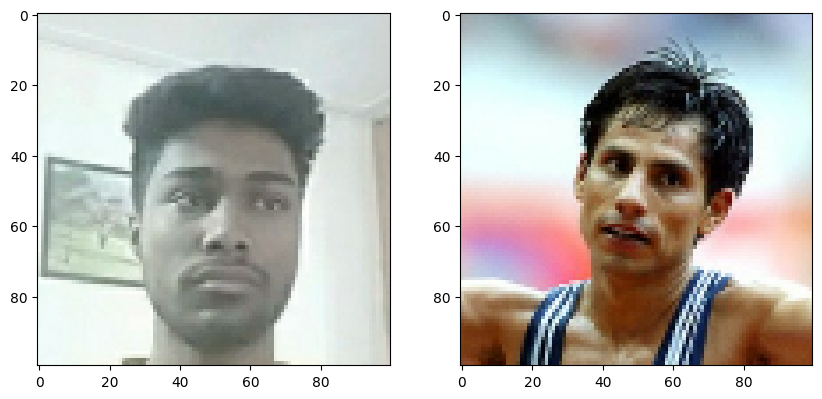

In [55]:
# Set plot size 
plt.figure(figsize=(10,8))

index=3

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[index])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[index])

# Renders cleanly
plt.show()

## Save Model

In [56]:
from keras.models import load_model

In [57]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [58]:
# Reload model
model = make_siamese_model()
model.load_weights('siamesemodelv2.h5')

# loaded_model = load_model('siamesemodelv2.h5', custom_objects={"L1Dist": L1Dist})

In [59]:
#Make predictions with reloaded model
model.predict([test_input, test_val])

array([[1.0316496e-10],
       [1.0000000e+00],
       [9.9998176e-01],
       [3.2142181e-10],
       [4.3368839e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999964e-01],
       [2.1166986e-10],
       [1.0000000e+00],
       [1.8580365e-11],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [4.0003878e-10]], dtype=float32)

In [60]:
os.listdir(os.path.join('application_data', 'verification_images'))

['0c474886-e0c0-11ed-a339-001a7dda7112.jpg',
 '0c518920-e0c0-11ed-895d-001a7dda7112.jpg',
 '0e43d86f-e0c0-11ed-b7d4-001a7dda7112.jpg',
 '0e4e13af-e0c0-11ed-a6b3-001a7dda7112.jpg',
 '1232ece3-e0c0-11ed-a801-001a7dda7112.jpg',
 '124237f5-e0c0-11ed-9bc4-001a7dda7112.jpg',
 '12474072-e0c0-11ed-a1f8-001a7dda7112.jpg',
 '1439d43e-e0c0-11ed-8a87-001a7dda7112.jpg',
 '1617e7dd-e0c0-11ed-9c4f-001a7dda7112.jpg',
 '16222363-e0c0-11ed-8893-001a7dda7112.jpg',
 '16272900-e0c0-11ed-8aaa-001a7dda7112.jpg',
 '163149a7-e0c0-11ed-b43d-001a7dda7112.jpg',
 '1819a81d-e0c0-11ed-86bb-001a7dda7112.jpg',
 '1a1b418a-e0c0-11ed-be42-001a7dda7112.jpg',
 '1a20580b-e0c0-11ed-b261-001a7dda7112.jpg',
 '61085453-e0be-11ed-9758-001a7dda7112.jpg',
 '6a0d9a94-e0be-11ed-9dd1-001a7dda7112.jpg',
 '6c0a388d-e0be-11ed-bd8f-001a7dda7112.jpg',
 '6c1449ea-e0be-11ed-9b0a-001a7dda7112.jpg',
 '6dfcacf6-e0be-11ed-8bc0-001a7dda7112.jpg',
 '6e1b250d-e0be-11ed-af6d-001a7dda7112.jpg',
 '70035e5b-e0be-11ed-8bb7-001a7dda7112.jpg',
 '7012b861

In [61]:
os.path.join('application_data', 'input_image', 'input_image.jpg')


'application_data\\input_image\\input_image.jpg'

In [62]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\0c474886-e0c0-11ed-a339-001a7dda7112.jpg
application_data\verification_images\0c518920-e0c0-11ed-895d-001a7dda7112.jpg
application_data\verification_images\0e43d86f-e0c0-11ed-b7d4-001a7dda7112.jpg
application_data\verification_images\0e4e13af-e0c0-11ed-a6b3-001a7dda7112.jpg
application_data\verification_images\1232ece3-e0c0-11ed-a801-001a7dda7112.jpg
application_data\verification_images\124237f5-e0c0-11ed-9bc4-001a7dda7112.jpg
application_data\verification_images\12474072-e0c0-11ed-a1f8-001a7dda7112.jpg
application_data\verification_images\1439d43e-e0c0-11ed-8a87-001a7dda7112.jpg
application_data\verification_images\1617e7dd-e0c0-11ed-9c4f-001a7dda7112.jpg
application_data\verification_images\16222363-e0c0-11ed-8893-001a7dda7112.jpg
application_data\verification_images\16272900-e0c0-11ed-8aaa-001a7dda7112.jpg
application_data\verification_images\163149a7-e0c0-11ed-b43d-001a7dda7112.jpg
application_data\verification_images\1819a81d-e0c0-11ed-86bb-001

In [63]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

Verification

In [64]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(1) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.8, 0.75)
        print(verified)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
True
True
False
True


In [68]:
np.sum(np.squeeze(results) > .9)

50

In [186]:
35/50

0.7